# # 1. Install and Import Libraries

In [1]:
!pip install -q tensorflow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# # 2. Prepare Toy Dataset

In [2]:
articles = [
    "The stock market crashed due to inflation fears.",
    "Apple released a new iPhone with better cameras.",
    "Scientists discovered a new exoplanet in the habitable zone.",
    "The football team won the championship after 10 years.",
    "A new species of bird was found in the Amazon rainforest."
]

summaries = [
    "Market crashed.",
    "New iPhone released.",
    "New planet discovered.",
    "Team wins title.",
    "New bird found."
]


#  3. Text Preprocessing

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

articles = [clean_text(a) for a in articles]
summaries = [clean_text(s) for s in summaries]


#  4. Tokenization

In [15]:
article_tokenizer = Tokenizer()
article_tokenizer.fit_on_texts(articles)
article_seq = article_tokenizer.texts_to_sequences(articles)
article_pad = pad_sequences(article_seq, padding='post')

summary_tokenizer = Tokenizer(filters='')
summary_tokenizer.fit_on_texts(summaries)
summary_seq = summary_tokenizer.texts_to_sequences(summaries)
summary_pad = pad_sequences(summary_seq, padding='post')

# Shift decoder inputs & outputs
decoder_input = [seq[:-1] for seq in summary_seq]
decoder_target = [seq[1:] for seq in summary_seq]
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

# Vocabulary sizes
article_vocab = len(article_tokenizer.word_index) + 1
summary_vocab = len(summary_tokenizer.word_index) + 1

#5. Positional Encoding

In [6]:
def get_positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)

# 6. Transformer Components

In [19]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Add a separate MultiHeadAttention layer for cross-attention
        self.cross_att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Add a layernorm for the cross-attention output
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Modify the call method to accept encoder_outputs for cross-attention
    def call(self, inputs, encoder_outputs=None):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)

        # Cross-attention (only if encoder_outputs are provided, i.e., in the decoder)
        if encoder_outputs is not None:
            # The query comes from the decoder input (out1), and the key/value from encoder_outputs
            cross_attn_output = self.cross_att(query=out1, value=encoder_outputs, key=encoder_outputs)
            out2 = self.layernorm2(out1 + cross_attn_output)
            # The feed-forward network takes the output of the cross-attention
            ffn_output = self.ffn(out2)
            return self.layernorm3(out2 + ffn_output)
        else:
            # If no encoder_outputs, perform only self-attention followed by feed-forward
            ffn_output = self.ffn(out1)
            return self.layernorm2(out1 + ffn_output)

# 7. Build Transformer Model

In [22]:
def build_transformer_model(article_vocab, summary_vocab, embed_dim=64, ff_dim=128, num_heads=2):
    # Encoder
    encoder_inputs = tf.keras.Input(shape=(None,), name='encoder_input')
    x = tf.keras.layers.Embedding(article_vocab, embed_dim)(encoder_inputs)
    x += get_positional_encoding(100, embed_dim)
    encoder_outputs = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Decoder
    decoder_inputs = tf.keras.Input(shape=(None,), name='decoder_input')
    x = tf.keras.layers.Embedding(summary_vocab, embed_dim)(decoder_inputs)
    x += get_positional_encoding(100, embed_dim)
    # Corrected: Change 'context' to 'encoder_outputs'
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, encoder_outputs=encoder_outputs)

    # Output layer
    outputs = tf.keras.layers.Dense(summary_vocab, activation='softmax')(x)

    model = tf.keras.Model([encoder_inputs, decoder_inputs], outputs)
    return model

# 8. Prepare Labels (One word summary ID)

In [23]:
target_labels = np.array([s[0] if len(s) > 0 else 0 for s in summary_seq])

# 9. Train the Model

In [24]:
history = model.fit(article_padded, target_labels, epochs=50, verbose=1)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0372
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0299
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0243
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0201
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.0167
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0139
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0119
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0102
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0088
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0077
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0062
E

# 10. Make Predictions

In [25]:
predictions = model.predict(article_padded)
predicted_ids = np.argmax(predictions, axis=1)

inv_summary_index = {v: k for k, v in summary_tokenizer.word_index.items()}
inv_summary_index[0] = "<PAD>"

print("\nSample Predictions:")
for i in range(len(articles)):
    pred_word = inv_summary_index.get(predicted_ids[i], "<UNK>")
    print(f"Article: {articles[i]}")
    print(f"Predicted Summary: {pred_word}")
    print(f"Actual Summary: {summaries[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Sample Predictions:
Article: the stock market crashed due to inflation fears
Predicted Summary: market
Actual Summary: market crashed
--------------------------------------------------
Article: apple released a new iphone with better cameras
Predicted Summary: new
Actual Summary: new iphone released
--------------------------------------------------
Article: scientists discovered a new exoplanet in the habitable zone
Predicted Summary: new
Actual Summary: new planet discovered
--------------------------------------------------
Article: the football team won the championship after 10 years
Predicted Summary: team
Actual Summary: team wins title
--------------------------------------------------
Article: a new species of bird was found in the amazon rainforest
Predicted Summary: new
Actual Summary: new bird found
--------------------------------------------------


# 11. Plot Loss

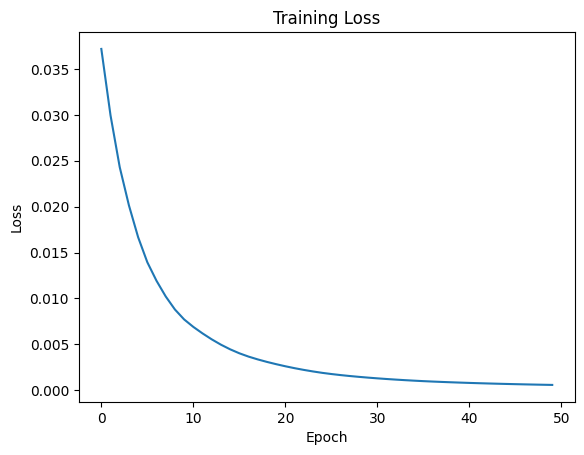

In [26]:
plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()